# CartPole

We install gymnasium which this is the library that contains among others, the environment of CartPole

In [ ]:
%%bash
pip3 install gymnasium[classic_control]

Importing libraries, generating the environment, setting the device and seed

In [ ]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from IPython import display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1") #We generate the environment with the name CartPole-v1

plt.ion() #To update the plots without generating news or crashing the script - Not necessary on Google Collab or Jupyter

#Use CPU just if no other alternative
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)


# To ensure reproducibility during training, you can fix the random seeds
# by uncommenting the lines below. This makes the results consistent across
# runs, which is helpful for debugging or comparing different approaches.
#
# That said, allowing randomness can be beneficial in practice, as it lets
# the model explore different training trajectories.


seed = 10
random.seed(seed)
torch.manual_seed(seed)
env.reset(seed=seed)
env.action_space.seed(seed)
env.observation_space.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

## Basic Functions

In order to demonstrate understanding of the tutorial, I modified the way we generate class to better understand the behavior. I introduce it in the script as a class. The replay memory is initialized in the same way as in the tutorial

In [ ]:
class Transition:
    def __init__(self, state, action, next_state, reward):
        self.state = state
        self.action = action
        self.next_state = next_state
        self.reward = reward


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity) #A list that erases the oldest element when the maximum len is reached

    def push(self, state, action, next_state, reward):
        transition = Transition(state, action, next_state, reward)
        self.memory.append(transition) #Saves each argument in memory

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size) #Gives a random sample -> destroy correlation in time

    def __len__(self):
        return len(self.memory) #size of memory

We initialize the DQN for both the policy and the target. Since CartPole is already an environment where we have four variables, there is no need to use CNN as there are no images.

In [ ]:
class DQN(nn.Module):
    #The network takes the environment state as input and outputs one Q-value per possible action.
    def __init__(self, n_observations, n_actions): #We use a fully connected NN with only two hidden layers and ReLu activation function
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Initializing the global parameters and key functions

In [ ]:
#BATCH_SIZE is the number of transitions sampled from the replay buffer
#GAMMA is the discount factor as mentioned in the previous section (how much future rewards are discounted)
#EPS_START is the starting value of epsilon (probability of random action at beggining)
#EPS_END is the final value of epsilon (same but at the end)
#EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay (how much does the epsilon evolves)
#TAU is the update rate of the target network
#LR is the learning rate of the ``AdamW`` optimizer

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.01
EPS_DECAY = 2500
TAU = 0.005
LR = 3e-4


#Number of actions from gym action space
n_actions = env.action_space.n
#Number of state observations
state, info = env.reset()
n_observations = len(state)

#Initializing the policy and target
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

#Adam optimizer
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
#Generating the Replay Memory with a size of 10000
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done #Number of actions taken by the agent
    sample = random.random() #something between 0 and 1
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY) #This helps us to get a small epsilon at the end and big at the bigining
    steps_done += 1
    if sample > eps_threshold: #If random elements superior to treshhold, then we use NN
       with torch.no_grad():
            # Compute Q-values for all actions and select the best one
            q_values = policy_net(state)
            best_action = q_values.max(dim=1).indices #Get the index of the action with bigger Q
            return best_action.view(1, 1) #view to resize
    else: #Else a random action
        random_action = env.action_space.sample()
        return torch.tensor([[random_action]],
                            device=device,
                            dtype=torch.long)


episode_durations = []

#Note that when I was testing the model, I generated intermediate plots where I could see that the model was training correctly
#Thus the reason why
def plot_durations(show_result=False):
    plt.figure(1) #Take first plot (and only)
    episode_lengths = torch.tensor(
        episode_durations,
        dtype=torch.float
    ) #transform to tensor
    if not show_result: #Show show plot during training
        plt.clf()
        plt.title("Training...")
    else:
        plt.title("Final Result")
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(episode_lengths.numpy(), label="Episode duration") #Plot it
    #Plot moving average over the last 100 episodes (if available)
    if len(episode_lengths) >= 100:
        moving_average = (
            episode_lengths
            .unfold(dimension=0, size=100, step=1)
            .mean(dim=1)
        )

        #Pad the beginning so the moving average aligns with episodes
        moving_average = torch.cat((
            torch.zeros(99),
            moving_average
        ))

        plt.plot(
            moving_average.numpy(),
            label="100-episode moving average"
        )

    plt.legend()

    #Small pause to allow matplotlib to update the figure
    plt.pause(0.001)

optimize_model takes a batch of past experiences and adjusts the neural network so that its Q-values approach the theoretical values defined by the Bellman equation.

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return #No training if not enough experiences
    transitions = memory.sample(BATCH_SIZE) #Get a sample of previous experiences not in chronological order to break time correlation
    states      = torch.cat([t.state for t in transitions])
    actions     = torch.cat([t.action for t in transitions])
    next_states = [t.next_state for t in transitions]
    rewards     = torch.cat([t.reward for t in transitions]) #Separate by type in experience (t, action, t+1, reward)

    non_final_mask = torch.tensor([s is not None for s in next_states], device=device, dtype=torch.bool) #To differentiate elements that are final states from those that are not
    non_final_next_states = torch.cat([s for s in next_states if s is not None]) #Concatenate
    state_batch = states #Separate by type of elements
    action_batch = actions
    reward_batch = reward

    state_action_values = policy_net(state_batch).gather(1, action_batch) #Compute all Qs and take the action with highest Q

    #Compute V(s_{t+1}) for all next states.
    #Expected values of actions for non_final_next_states are computed based
    #on the "older" target_net; selecting their best reward with max(1).values
    #This is merged based on the mask, such that we'll have either the expected
    #state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device) #Tensor of size batch_size with only 0s
    with torch.no_grad(): #Don't compute gradients
      non_final_index = 0
      for i, is_non_terminal in enumerate(non_final_mask): #Among all elements
        if is_non_terminal: #If it is not terminal
          next_state = non_final_next_states[non_final_index] #Get the index
          next_state_values[i] = target_net(next_state).max() #Get the value
          non_final_index += 1


    expected_state_action_values = (next_state_values * GAMMA) + reward_batch #Compute the expected Q values
    criterion = nn.SmoothL1Loss() #Hubber loss
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1)) #Compute loss
    optimizer.zero_grad() #Put to zero the gradients
    loss.backward() #Backward propagation
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step() #Optimize

## Training ! And metric 1

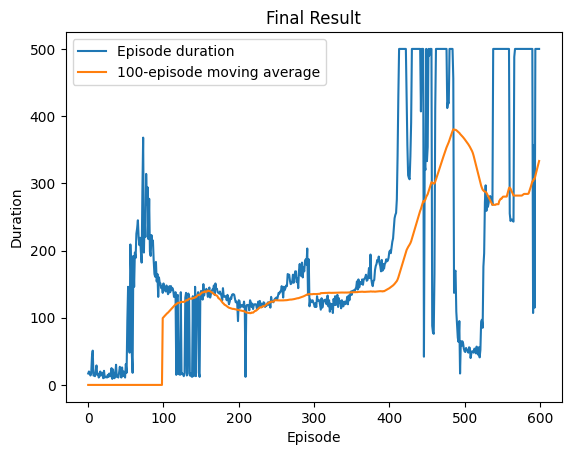

In [ ]:
num_episodes = 500 #After 60 episodes we have 200 duraction (= reward)

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            #plot_durations()
            break

plot_durations(show_result=True)
plt.ioff()
plt.show()

### Gif

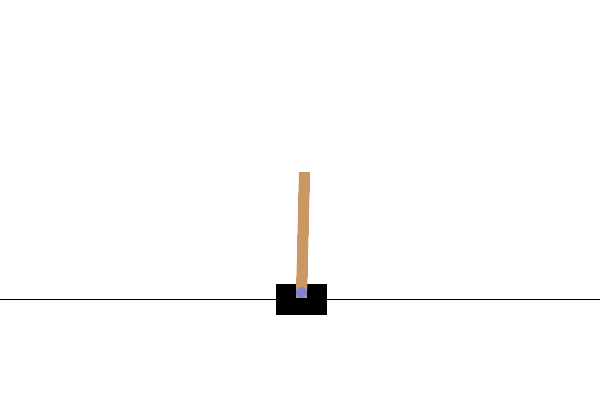

In [ ]:
import io
import imageio
from IPython.display import Image, display

EPS_VIS = 0.05  #5% of random actions

env_gif = gym.make("CartPole-v1", render_mode="rgb_array")

all_frames = [] # List to store frames from all episodes
num_evaluation_episodes = 5 #Number of episodes to run for GIF

for _ in range(num_evaluation_episodes):
    state, _ = env_gif.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    done = False
    while not done:

        #ε-greedy for vizualisation
        if random.random() < EPS_VIS:
            action = env_gif.action_space.sample()
        else:
            with torch.no_grad():
                action = policy_net(state).max(1).indices.item()

        next_state, reward, terminated, truncated, _ = env_gif.step(action)
        done = terminated or truncated

        all_frames.append(env_gif.render())

        if not done:
            state = torch.tensor(
                next_state, dtype=torch.float32, device=device
            ).unsqueeze(0)

env_gif.close()

gif_bytes = io.BytesIO()
imageio.mimsave(gif_bytes, all_frames, format="GIF", fps=30, loop=0) #loop=0 for indefinite looping

display(Image(data=gif_bytes.getvalue()))


### Save the generated GIF to a file

In [ ]:
output_filename = "cartpole_animation.gif"

with open(output_filename, "wb") as f:
    f.write(gif_bytes.getvalue())

print(f"GIF successfully saved as '{output_filename}' in your Colab environment.")

GIF successfully saved as 'cartpole_animation.gif' in your Colab environment.


## Metric 2



Selecting the 128 states

In [ ]:
env_fixed_states = gym.make("CartPole-v1") #Create a new environment for state collection
fixed_states_list = [] #Initialize an empty list to store the collected states

#Reset the environment to obtain the initial state
state, info = env_fixed_states.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

#Loop to collect 128 states
for _ in range(128):
    # Append the current state to the list
    fixed_states_list.append(state)

    #Select a random action
    action = env_fixed_states.action_space.sample()

    #Take a step in the environment
    observation, reward, terminated, truncated, _ = env_fixed_states.step(action)
    done = terminated or truncated

    if done:
        #If episode terminates, reset the environment for a new initial state
        state, info = env_fixed_states.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    else:
        #Convert the observation into a PyTorch tensor
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

#Concatenate all the individual state tensors into a single PyTorch tensor
fixed_states = torch.cat(fixed_states_list, dim=0)
env_fixed_states.close() #Close the environment after collection

print(f"Collected {fixed_states.shape[0]} fixed states with shape {fixed_states.shape}")

Collected 128 fixed states with shape torch.Size([128, 4])


Compute average max of Q

In [ ]:
def calculate_avg_max_q(policy_net, fixed_states):
    """
    Computes the average of the maximum predicted Q-value for a fixed set of states.

    Args:
        policy_net (nn.Module): The current policy network.
        fixed_states (torch.Tensor): A tensor of fixed states to evaluate.

    Returns:
        float: The average of the maximum Q-values across the fixed states.
    """
    with torch.no_grad():
        # Pass fixed_states through the policy_net to get Q-values for all actions
        q_values = policy_net(fixed_states)
        # Find the maximum Q-value for each state
        max_q_values = q_values.max(dim=1).values
        # Calculate the average of these maximum Q-values
        avg_max_q = max_q_values.mean().item()
    return avg_max_q

# Initialize a list to store the average maximum Q-values during training
avg_max_q_values = []

print("Function `calculate_avg_max_q` defined and `avg_max_q_values` list initialized.")

Function `calculate_avg_max_q` defined and `avg_max_q_values` list initialized.


Plot function:

In [ ]:
def plot_avg_max_q(show_result=False):
    plt.figure(2)
    avg_max_q_tensor = torch.tensor(
        avg_max_q_values,
        dtype=torch.float
    )

    if not show_result:
        plt.clf()
        plt.title("Average Max Q-value During Training")
    else:
        plt.title("Final Average Max Q-value")
    plt.xlabel('Episode')
    plt.ylabel('Average Max Q-value')
    plt.plot(avg_max_q_tensor.numpy(), label="Average Max Q-value")

    # Plot moving average over the last 100 episodes (if available)
    if len(avg_max_q_tensor) >= 100:
        moving_average = (
            avg_max_q_tensor
            .unfold(dimension=0, size=100, step=1)
            .mean(dim=1)
        )

        # Pad the beginning so the moving average aligns with episodes
        moving_average = torch.cat((
            torch.zeros(99),
            moving_average
        ))

    plt.legend()
    plt.pause(0.001)

print("Function `plot_avg_max_q` defined.")

Function `plot_avg_max_q` defined.


Just as before : training

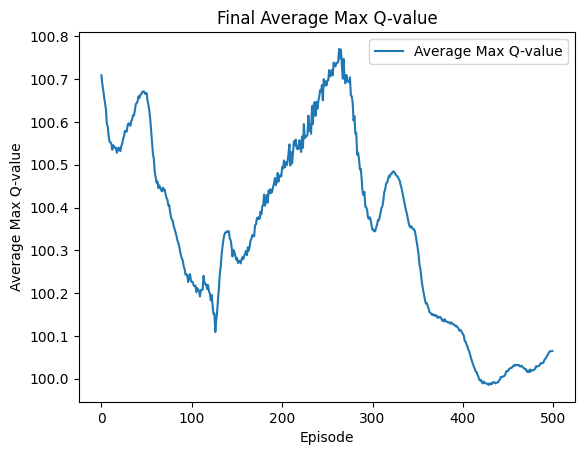

In [ ]:
num_episodes = 500

for i_episode in range(num_episodes):
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break

    # Calculate and store average max Q-value for fixed states
    avg_max_q = calculate_avg_max_q(policy_net, fixed_states)
    avg_max_q_values.append(avg_max_q)

plot_avg_max_q(show_result=True)
plt.ioff()
plt.show()


## Metric 3

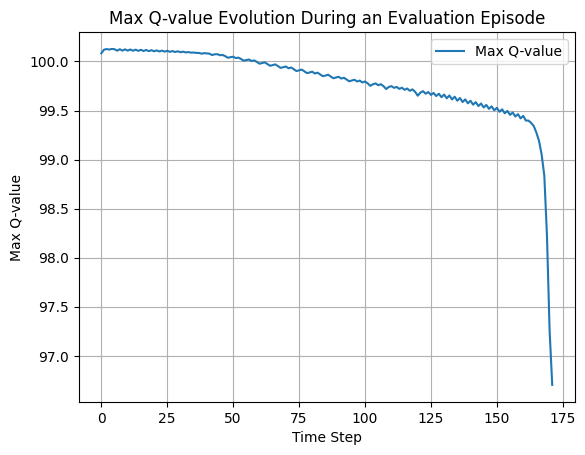

Evaluated episode with 172 steps. Max Q-value evolution plotted.


In [ ]:
def visualize_value_function_episode(policy_net, env_to_visualize, device):
    max_q_values_per_step = []
    episode_steps = []

    state, _ = env_to_visualize.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    done = False
    step_count = 0

    for t in count():
        #Calculate the maximum Q-value for the current state
        with torch.no_grad():
            q_values = policy_net(state)
            max_q_value = q_values.max(1).values.item()
            max_q_values_per_step.append(max_q_value)

            #Select action based on policy_net's output (greedy)
            action = q_values.max(1).indices.item()

        #Take a step in the environment
        next_state_obs, _, terminated, truncated, _ = env_to_visualize.step(action)
        done = terminated or truncated

        #Update state
        if not done:
            state = torch.tensor(next_state_obs, dtype=torch.float32, device=device).unsqueeze(0)

        episode_steps.append(t)

        if done:
            break

    #Plotting
    plt.figure()
    plt.plot(episode_steps, max_q_values_per_step, label='Max Q-value')
    plt.xlabel('Time Step')
    plt.ylabel('Max Q-value')
    plt.title('Max Q-value Evolution During an Evaluation Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Evaluated episode with {len(episode_steps)} steps. Max Q-value evolution plotted.")

#Create a new environment specifically for visualization to avoid interfering with training
env_for_visualization = gym.make("CartPole-v1")

#Call the function to visualize the value function
visualize_value_function_episode(policy_net, env_for_visualization, device)

env_for_visualization.close()


## Metric 4


In [ ]:
def evaluate_direction(policy_net, episodes=1000):
    left_falls = 0
    right_falls = 0

    for _ in range(episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        done = False
        while not done:
            with torch.no_grad():
                action = policy_net(state).max(1).indices.item()

            next_state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if not done:
                state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)

        # posición final del carrito
        final_pos = state[0, 0].item()
        if final_pos < 0:
            left_falls += 1
        else:
            right_falls += 1

    print("Falls left :", left_falls)
    print("Falls right:", right_falls)
evaluate_direction(policy_net)


Falls left : 0
Falls right: 1000
